In [1]:
%matplotlib inline

# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()

import importlib
from libs import params, trades, feats, plots, models_core, models_custom
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(models_custom)

<module 'libs.models_custom' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_custom.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
from torch.nn import MSELoss, Dropout
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau, OneCycleLR
from torch.amp import GradScaler

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,in_sess_time,eng_vwap,dist_low_30,eng_ema_cross_down,dist_low_28,eng_ema_cross_up,dist_low_10,dist_low_5,hour_time,dist_high_30,rsi_10,dist_low_2,minute_time,rsi_30,sma_pct_28,rsi,dist_high_10,obv_z_2,adx_30,rsi_5,adx_60,eng_bb_mid,z_vwap_dev_60,dist_high_5,vwap_dev_pct_10,vwap_dev_pct,sma_pct_14,plus_di,sma_pct_10,plus_di_10,vwap_dev_pct_30,adx,rsi_2,z_vwap_dev_30,roc_10,roc_14,obv_diff_14,vwap_dev_pct_60,plus_di_5,rsi_60,roc_5,obv_diff_10,sma_pct_60,obv_pct_60,minus_di_2,obv_diff_30,obv_pct_14,obv_pct_30,eng_ma,obv_diff_60,close_raw,signal
2009-01-02 10:00:00,0.0,0.491010,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.506309,1.000000,0.000000,0.918194,0.000000,1.000000,0.000000,0.488646,0.496275,0.000000,0.500549,0.500132,0.507274,0.000000,0.505812,0.000000,0.496816,0.000000,1.000000,0.500684,0.502497,0.502131,0.588487,0.492321,0.000000,1.000000,0.499147,0.576647,0.513657,1.000000,0.000000,0.615784,1.000000,1.000000,0.504047,0.644459,3.069643,6.503025e-09
2009-01-02 10:01:00,0.0,0.491010,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.001515,1.000000,0.506309,1.000000,0.000000,0.918194,0.000000,1.000000,0.000000,0.488646,0.496275,0.000000,0.500549,0.500132,0.507274,0.000000,0.505812,0.000000,0.496816,0.000000,1.000000,0.500684,0.502497,0.502131,0.588487,0.492321,0.000000,1.000000,0.499147,0.576647,0.513657,1.000000,0.000000,0.615784,1.000000,1.000000,0.504047,0.644459,3.069643,6.951338e-09
2009-01-02 10:02:00,0.0,0.491010,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.003030,1.000000,0.506309,1.000000,0.000000,0.918194,0.000000,1.000000,0.000000,0.488646,0.496275,0.000000,0.500549,0.500132,0.507274,0.000000,0.505812,0.000000,0.496816,0.000000,1.000000,0.500684,0.502497,0.502131,0.588487,0.492321,0.000000,1.000000,0.499147,0.576647,0.513657,1.000000,0.000000,0.615784,1.000000,1.000000,0.504047,0.644459,3.069643,7.430557e-09
2009-01-02 10:03:00,0.0,0.491010,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.004545,1.000000,0.506309,1.000000,0.000000,0.918194,0.000000,1.000000,0.000000,0.488646,0.496275,0.000000,0.500549,0.500132,0.507274,0.000000,0.505812,0.000000,0.496816,0.000000,1.000000,0.500684,0.502497,0.502131,0.588487,0.492321,0.000000,1.000000,0.499147,0.576647,0.513657,1.000000,0.000000,0.615784,1.000000,1.000000,0.504047,0.644459,3.069643,7.942813e-09
2009-01-02 10:04:00,0.0,0.491010,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.006061,1.000000,0.506309,1.000000,0.000000,0.918194,0.000000,1.000000,0.000000,0.488646,0.496275,0.000000,0.500549,0.500132,0.507274,0.000000,0.505812,0.000000,0.496816,0.000000,1.000000,0.500684,0.502497,0.502131,0.588487,0.492321,0.000000,1.000000,0.499147,0.576647,0.513657,1.000000,0.000000,0.615784,1.000000,1.000000,0.504047,0.644459,3.069643,8.490383e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,1.0,0.705553,0.300176,0.0,0.308320,1.0,0.280791,0.287161,0.909091,0.000000,0.696531,0.171209,0.993939,0.611989,0.657535,0.672166,0.000000,0.803503,0.142115,0.757919,0.097797,0.343395,0.661181,0.000000,0.611728,0.613651,0.660294,0.363125,0.658361,0.379828,0.627366,0.301944,0.913589,0.714079,0.662080,0.651913,1.000000,0.643060,0.393473,0.560401,0.679721,1.000000,0.671360,0.362745,0.001927,1.000000,0.595813,0.464988,0.644897,1.000000,196.815000,1.654708e-01
2025-06-18 20:57:00,1.0,0.576493,0.264901,0.0,0.232389,1.0,0.188511,0.111566,0.909091,0.035318,0.620717,0.000000,0.995454,0.586018,0.612977,0.616686,0.062555,0.000000,0.151717,0.608613,0.099996,0.391649,0.608628,0.093853,0.532076,0.545331,0.598576,0.347207,0.577436,0.357138,0.576438,0.328685,0.451818,0.550035,0.616286,0.593538,1.000000,0.603899,0.351983,0.547599,0.591098,1

In [4]:
train_loader, val_loader, test_loader, end_times_tr, end_times_val, end_times_te = models_core.model_core_pipeline(
    df             = df_feat_sel,
    look_back      = params.hparams["LOOK_BACK"],
    sess_start     = params.sess_start_pred_tick,
    train_prop     = params.train_prop,
    val_prop       = params.val_prop,
    train_batch    = params.hparams["TRAIN_BATCH"],
    train_workers  = params.hparams["TRAIN_WORKERS"],
    prefetch_factor= params.hparams["TRAIN_PREFETCH_FACTOR"],
    signal_thresh  = params.best_optuna_params["buy_threshold"],
    return_thresh  = params.return_threshold_tick
)

Preparing days:   0%|          | 0/4141 [00:00<?, ?it/s]

N_total: 1991821 look_back: 90 F: 50
Estimated X_buf size: 35.85 GB — using RAM (in-memory) (thresh 36 GiB)


Writing days:   0%|          | 0/4141 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

In [5]:
for name, ld, tm in zip(
    ["train","val","test"],
    [train_loader, val_loader, test_loader],
    [end_times_tr, end_times_val, end_times_te]
):
    models_core.summarize_split(name, ld, tm)


--- TRAIN ---
 calendar days : 2912  (2009-01-02 → 2020-07-28)
 windows       : 1400672  (per-day min=481, max=481, mean=481.0)
 window shape  : look_back=90, n_features=50
 dataloader    : batches=182, batch_size=16, workers=8, pin_memory=True
 baselines     : baseline prediction=0.086813, baseline RMSE = 0.100132

--- VAL ---
 calendar days : 608  (2020-07-29 → 2022-12-23)
 windows       : 292448  (per-day min=481, max=481, mean=481.0)
 window shape  : look_back=90, n_features=50
 dataloader    : batches=608, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.103168, baseline RMSE = 0.109437

--- TEST ---
 calendar days : 621  (2022-12-27 → 2025-06-18)
 windows       : 298701  (per-day min=481, max=481, mean=481.0)
 window shape  : look_back=90, n_features=50
 dataloader    : batches=621, batch_size=1, workers=0, pin_memory=True
 baselines     : baseline prediction=0.0889464, baseline RMSE = 0.0983934



In [6]:
# importlib.reload(models_custom) #############

# -----------------------------------------------------------------------------
# Instantiate the ModelClass & move to device
# -----------------------------------------------------------------------------

model = models_custom.ModelClass(
    n_feats             = len(params.features_cols_tick),
    short_units         = params.hparams["SHORT_UNITS"],
    long_units          = params.hparams["LONG_UNITS"],
    transformer_d_model = params.hparams["TRANSFORMER_D_MODEL"],
    transformer_layers  = params.hparams["TRANSFORMER_LAYERS"],
    dropout_short       = params.hparams["DROPOUT_SHORT"],
    dropout_long        = params.hparams["DROPOUT_LONG"],
    dropout_trans       = params.hparams["DROPOUT_TRANS"],
    pred_hidden         = params.hparams["PRED_HIDDEN"],
    look_back           = params.hparams["LOOK_BACK"],

    # Gating flags
    use_conv            = params.hparams["USE_CONV"],
    use_tcn             = params.hparams["USE_TCN"],
    use_short_lstm      = params.hparams["USE_SHORT_LSTM"],
    use_transformer     = params.hparams["USE_TRANSFORMER"],
    use_long_lstm       = params.hparams["USE_LONG_LSTM"],
    use_delta           = params.hparams["USE_DELTA"],
    flatten_mode        = params.hparams["FLATTEN_MODE"]
)

model.feature_names = params.features_cols_tick # for logging
model.to(params.device)  
    
model

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:375: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ModelClass(
  (conv): Identity()
  (bn): Identity()
  (relu): ReLU()
  (tcn): Identity()
  (ln_short): Identity()
  (do_short): Identity()
  (feature_proj): Linear(in_features=50, out_features=64, bias=True)
  (pos_enc): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (shor

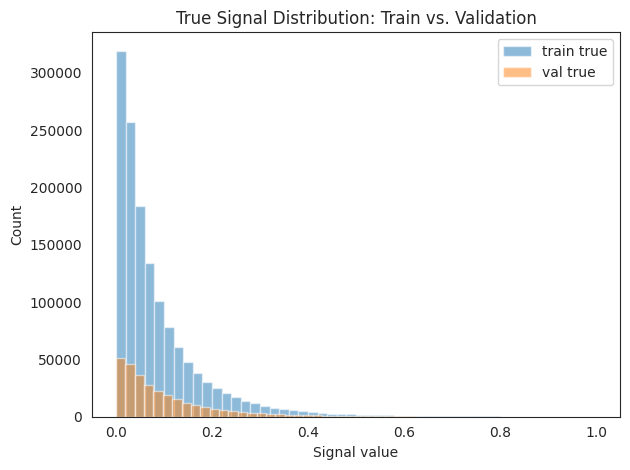

In [7]:
y_train = np.concatenate([batch[1].cpu().numpy().ravel() for batch in train_loader])
y_val = np.concatenate([batch[1].cpu().numpy().ravel() for batch in val_loader])

# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=50, alpha=0.5, label="train true")
plt.hist(y_val,   bins=50, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
optimizer = AdamW(
  model.parameters(),
  lr           = params.hparams["ONECYCLE_MAX_LR"],
  weight_decay = params.hparams["WEIGHT_DECAY"]
)

batches_per_epoch = len(train_loader)
total_steps = batches_per_epoch * params.hparams["MAX_EPOCHS"]

scheduler = OneCycleLR(
  optimizer,
  max_lr           = params.hparams["ONECYCLE_MAX_LR"],
  total_steps      = total_steps,
  pct_start        = params.hparams["ONECYCLE_PCT_START"],
  div_factor       = params.hparams["ONECYCLE_DIV_FACTOR"],
  final_div_factor = params.hparams["ONECYCLE_FINAL_DIV"],
  anneal_strategy  = params.hparams["ONECYCLE_STRATEGY"],
)
optimizer.scheduler = scheduler # necessary to log sched_field

if getattr(scheduler, "total_steps", None) != total_steps:
    raise RuntimeError(f"Scheduler total_steps mismatch: scheduler={getattr(scheduler,'total_steps',None)} expected={total_steps}")

Training sees 2912 unique trading days per epoch.

Model parameters: total=120,579, trainable=120,579

Using HyperParameters:
 {'USE_CONV': False, 'CONV_K': 3, 'CONV_DILATION': 1, 'CONV_CHANNELS': 64, 'USE_TCN': False, 'TCN_LAYERS': 3, 'TCN_KERNEL': 3, 'TCN_CHANNELS': 128, 'USE_SHORT_LSTM': False, 'SHORT_UNITS': 128, 'DROPOUT_SHORT': 0.15, 'USE_TRANSFORMER': True, 'TRANSFORMER_D_MODEL': 64, 'TRANSFORMER_LAYERS': 2, 'TRANSFORMER_HEADS': 4, 'TRANSFORMER_FF_MULT': 4, 'DROPOUT_TRANS': 0.2, 'USE_LONG_LSTM': False, 'DROPOUT_LONG': 0.1, 'LONG_UNITS': 128, 'FLATTEN_MODE': 'pool', 'PRED_HIDDEN': 64, 'ALPHA_SMOOTH': 0.0, 'WARMUP_STEPS': 5, 'USE_HUBER': False, 'HUBER_DELTA': 0.1, 'USE_DELTA': False, 'LAMBDA_DELTA': 0.1, 'MAX_EPOCHS': 90, 'EARLY_STOP_PATIENCE': 9, 'WEIGHT_DECAY': 0.0002, 'CLIPNORM': 2, 'ONECYCLE_MAX_LR': 0.0008, 'ONECYCLE_DIV_FACTOR': 10, 'ONECYCLE_FINAL_DIV': 100, 'ONECYCLE_PCT_START': 0.1, 'ONECYCLE_STRATEGY': 'cos', 'TRAIN_BATCH': 16, 'VAL_BATCH': 1, 'TRAIN_WORKERS': 8, 'TRAIN_

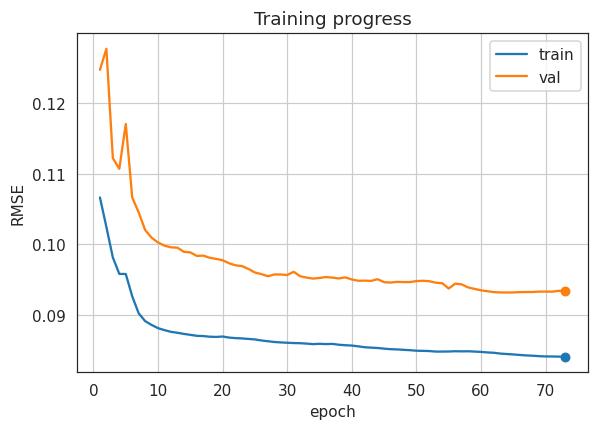

Epoch 1 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

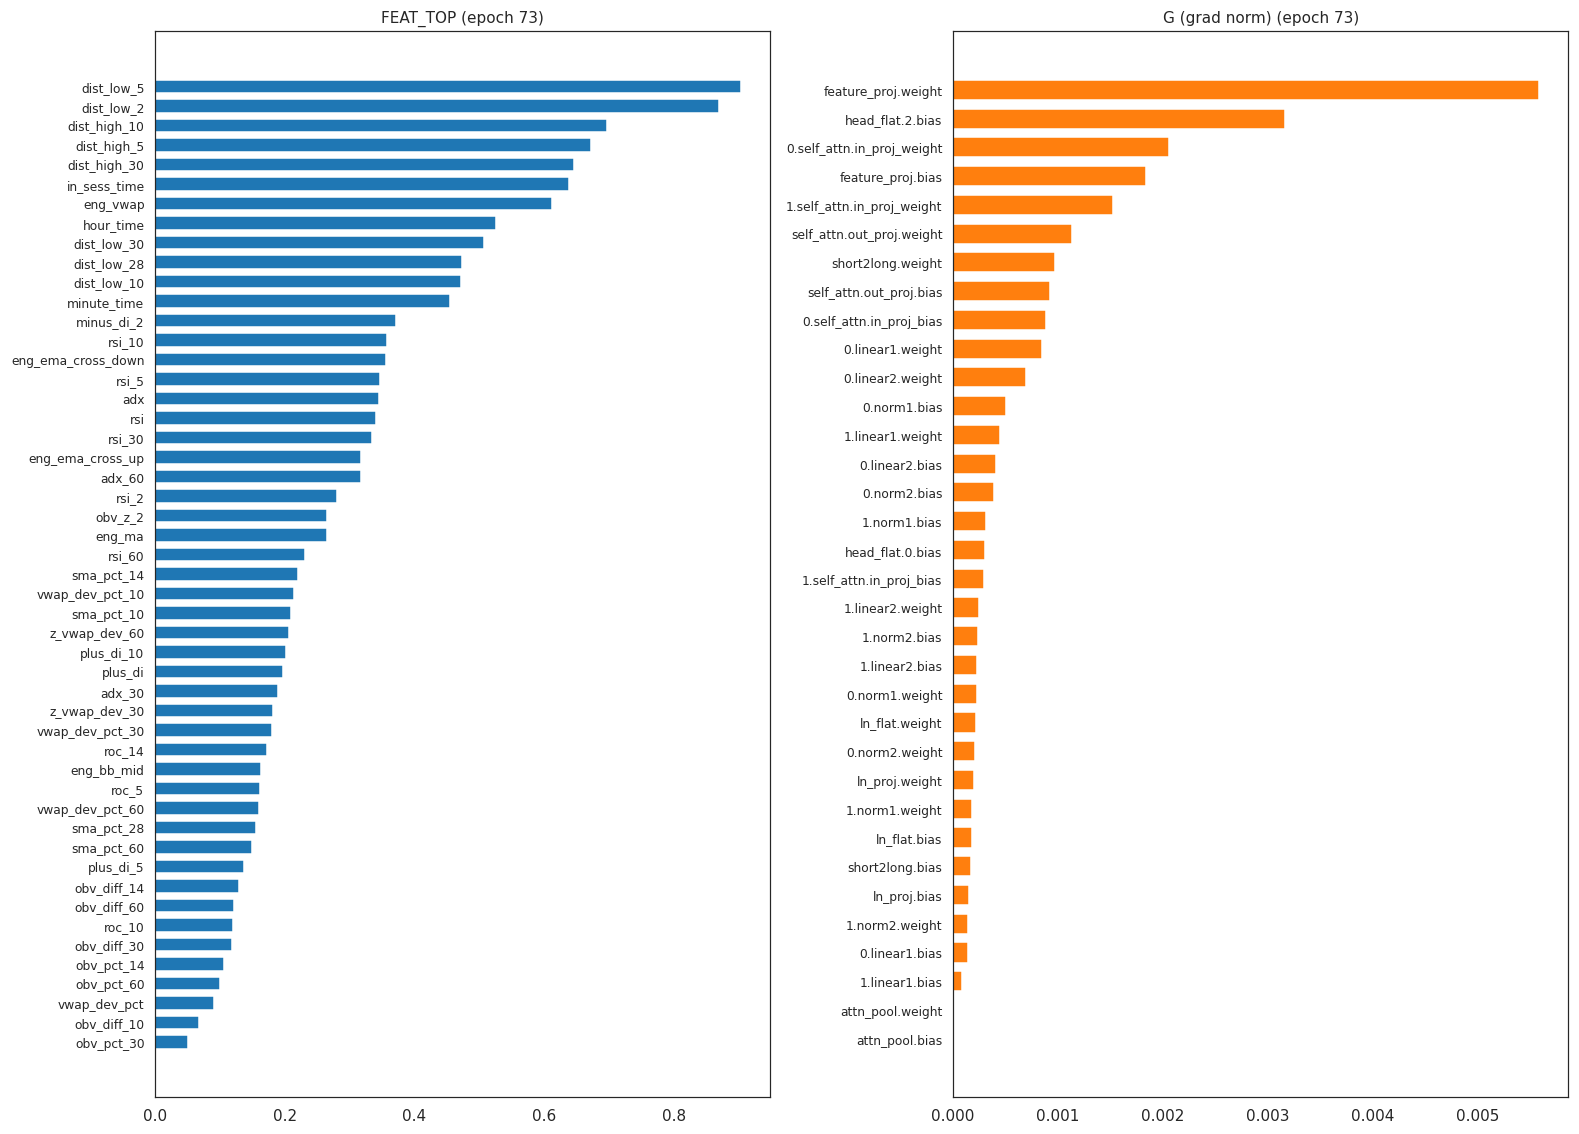

Epoch 01  TRAIN→ RMSE=0.10664, R²=-0.134 |  VALID→ RMSE=0.12472, R²=-0.299 |  lr=1.02e-04 |  loss=1.13730e-02 |  improved=True


Epoch 2 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 02  TRAIN→ RMSE=0.10246, R²=-0.047 |  VALID→ RMSE=0.12770, R²=-0.362 |  lr=1.64e-04 |  loss=1.04972e-02 |  improved=False


Epoch 3 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 03  TRAIN→ RMSE=0.09814, R²=0.039 |  VALID→ RMSE=0.11221, R²=-0.051 |  lr=2.60e-04 |  loss=9.63241e-03 |  improved=True


Epoch 4 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 04  TRAIN→ RMSE=0.09582, R²=0.084 |  VALID→ RMSE=0.11070, R²=-0.023 |  lr=3.78e-04 |  loss=9.18072e-03 |  improved=True


Epoch 5 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 05  TRAIN→ RMSE=0.09580, R²=0.085 |  VALID→ RMSE=0.11705, R²=-0.144 |  lr=5.03e-04 |  loss=9.17805e-03 |  improved=False


Epoch 6 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 06  TRAIN→ RMSE=0.09264, R²=0.144 |  VALID→ RMSE=0.10663, R²=0.051 |  lr=6.20e-04 |  loss=8.58240e-03 |  improved=True


Epoch 7 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 07  TRAIN→ RMSE=0.09023, R²=0.188 |  VALID→ RMSE=0.10452, R²=0.088 |  lr=7.16e-04 |  loss=8.14184e-03 |  improved=True


Epoch 8 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 08  TRAIN→ RMSE=0.08913, R²=0.208 |  VALID→ RMSE=0.10203, R²=0.131 |  lr=7.78e-04 |  loss=7.94370e-03 |  improved=True


Epoch 9 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 09  TRAIN→ RMSE=0.08858, R²=0.217 |  VALID→ RMSE=0.10094, R²=0.149 |  lr=8.00e-04 |  loss=7.84701e-03 |  improved=True


Epoch 10 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 10  TRAIN→ RMSE=0.08813, R²=0.225 |  VALID→ RMSE=0.10026, R²=0.161 |  lr=8.00e-04 |  loss=7.76626e-03 |  improved=True


Epoch 11 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 11  TRAIN→ RMSE=0.08785, R²=0.230 |  VALID→ RMSE=0.09981, R²=0.168 |  lr=7.99e-04 |  loss=7.71766e-03 |  improved=True


Epoch 12 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 12  TRAIN→ RMSE=0.08761, R²=0.235 |  VALID→ RMSE=0.09958, R²=0.172 |  lr=7.97e-04 |  loss=7.67501e-03 |  improved=True


Epoch 13 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 13  TRAIN→ RMSE=0.08747, R²=0.237 |  VALID→ RMSE=0.09953, R²=0.173 |  lr=7.95e-04 |  loss=7.65181e-03 |  improved=True


Epoch 14 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 14  TRAIN→ RMSE=0.08732, R²=0.240 |  VALID→ RMSE=0.09894, R²=0.183 |  lr=7.92e-04 |  loss=7.62394e-03 |  improved=True


Epoch 15 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 15  TRAIN→ RMSE=0.08718, R²=0.242 |  VALID→ RMSE=0.09886, R²=0.184 |  lr=7.89e-04 |  loss=7.60065e-03 |  improved=True


Epoch 16 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 16  TRAIN→ RMSE=0.08704, R²=0.244 |  VALID→ RMSE=0.09836, R²=0.192 |  lr=7.85e-04 |  loss=7.57650e-03 |  improved=True


Epoch 17 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 17  TRAIN→ RMSE=0.08701, R²=0.245 |  VALID→ RMSE=0.09840, R²=0.191 |  lr=7.81e-04 |  loss=7.57102e-03 |  improved=False


Epoch 18 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 18  TRAIN→ RMSE=0.08692, R²=0.247 |  VALID→ RMSE=0.09810, R²=0.196 |  lr=7.76e-04 |  loss=7.55474e-03 |  improved=True


Epoch 19 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 19  TRAIN→ RMSE=0.08689, R²=0.247 |  VALID→ RMSE=0.09794, R²=0.199 |  lr=7.70e-04 |  loss=7.54919e-03 |  improved=True


Epoch 20 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 20  TRAIN→ RMSE=0.08695, R²=0.246 |  VALID→ RMSE=0.09775, R²=0.202 |  lr=7.64e-04 |  loss=7.55950e-03 |  improved=True


Epoch 21 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 21  TRAIN→ RMSE=0.08679, R²=0.249 |  VALID→ RMSE=0.09732, R²=0.209 |  lr=7.57e-04 |  loss=7.53298e-03 |  improved=True


Epoch 22 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 22  TRAIN→ RMSE=0.08672, R²=0.250 |  VALID→ RMSE=0.09703, R²=0.214 |  lr=7.50e-04 |  loss=7.52025e-03 |  improved=True


Epoch 23 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 23  TRAIN→ RMSE=0.08667, R²=0.251 |  VALID→ RMSE=0.09692, R²=0.216 |  lr=7.42e-04 |  loss=7.51233e-03 |  improved=True


Epoch 24 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 24  TRAIN→ RMSE=0.08661, R²=0.252 |  VALID→ RMSE=0.09651, R²=0.222 |  lr=7.34e-04 |  loss=7.50043e-03 |  improved=True


Epoch 25 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 25  TRAIN→ RMSE=0.08653, R²=0.253 |  VALID→ RMSE=0.09601, R²=0.230 |  lr=7.25e-04 |  loss=7.48779e-03 |  improved=True


Epoch 26 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 26  TRAIN→ RMSE=0.08639, R²=0.256 |  VALID→ RMSE=0.09579, R²=0.234 |  lr=7.16e-04 |  loss=7.46237e-03 |  improved=True


Epoch 27 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 27  TRAIN→ RMSE=0.08628, R²=0.258 |  VALID→ RMSE=0.09548, R²=0.239 |  lr=7.06e-04 |  loss=7.44369e-03 |  improved=True


Epoch 28 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 28  TRAIN→ RMSE=0.08617, R²=0.259 |  VALID→ RMSE=0.09573, R²=0.235 |  lr=6.96e-04 |  loss=7.42547e-03 |  improved=False


Epoch 29 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 29  TRAIN→ RMSE=0.08611, R²=0.260 |  VALID→ RMSE=0.09573, R²=0.235 |  lr=6.86e-04 |  loss=7.41512e-03 |  improved=False


Epoch 30 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 30  TRAIN→ RMSE=0.08606, R²=0.261 |  VALID→ RMSE=0.09566, R²=0.236 |  lr=6.75e-04 |  loss=7.40687e-03 |  improved=False


Epoch 31 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 31  TRAIN→ RMSE=0.08602, R²=0.262 |  VALID→ RMSE=0.09612, R²=0.229 |  lr=6.63e-04 |  loss=7.39920e-03 |  improved=False


Epoch 32 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 32  TRAIN→ RMSE=0.08600, R²=0.262 |  VALID→ RMSE=0.09548, R²=0.239 |  lr=6.51e-04 |  loss=7.39551e-03 |  improved=False


Epoch 33 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 33  TRAIN→ RMSE=0.08594, R²=0.263 |  VALID→ RMSE=0.09529, R²=0.242 |  lr=6.39e-04 |  loss=7.38636e-03 |  improved=True


Epoch 34 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 34  TRAIN→ RMSE=0.08587, R²=0.265 |  VALID→ RMSE=0.09515, R²=0.244 |  lr=6.26e-04 |  loss=7.37293e-03 |  improved=True


Epoch 35 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 35  TRAIN→ RMSE=0.08591, R²=0.264 |  VALID→ RMSE=0.09524, R²=0.243 |  lr=6.13e-04 |  loss=7.38101e-03 |  improved=False


Epoch 36 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 36  TRAIN→ RMSE=0.08587, R²=0.265 |  VALID→ RMSE=0.09537, R²=0.241 |  lr=6.00e-04 |  loss=7.37407e-03 |  improved=False


Epoch 37 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 37  TRAIN→ RMSE=0.08590, R²=0.264 |  VALID→ RMSE=0.09529, R²=0.242 |  lr=5.87e-04 |  loss=7.37844e-03 |  improved=False


Epoch 38 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 38  TRAIN→ RMSE=0.08578, R²=0.266 |  VALID→ RMSE=0.09517, R²=0.244 |  lr=5.73e-04 |  loss=7.35877e-03 |  improved=False


Epoch 39 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 39  TRAIN→ RMSE=0.08571, R²=0.267 |  VALID→ RMSE=0.09532, R²=0.241 |  lr=5.59e-04 |  loss=7.34648e-03 |  improved=False


Epoch 40 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 40  TRAIN→ RMSE=0.08566, R²=0.268 |  VALID→ RMSE=0.09503, R²=0.246 |  lr=5.44e-04 |  loss=7.33818e-03 |  improved=True


Epoch 41 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 41  TRAIN→ RMSE=0.08555, R²=0.270 |  VALID→ RMSE=0.09484, R²=0.249 |  lr=5.30e-04 |  loss=7.31950e-03 |  improved=True


Epoch 42 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 42  TRAIN→ RMSE=0.08542, R²=0.272 |  VALID→ RMSE=0.09486, R²=0.249 |  lr=5.15e-04 |  loss=7.29720e-03 |  improved=False


Epoch 43 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 43  TRAIN→ RMSE=0.08537, R²=0.273 |  VALID→ RMSE=0.09482, R²=0.249 |  lr=5.00e-04 |  loss=7.28807e-03 |  improved=True


Epoch 44 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 44  TRAIN→ RMSE=0.08532, R²=0.274 |  VALID→ RMSE=0.09507, R²=0.245 |  lr=4.85e-04 |  loss=7.27944e-03 |  improved=False


Epoch 45 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 45  TRAIN→ RMSE=0.08523, R²=0.276 |  VALID→ RMSE=0.09464, R²=0.252 |  lr=4.70e-04 |  loss=7.26363e-03 |  improved=True


Epoch 46 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 46  TRAIN→ RMSE=0.08515, R²=0.277 |  VALID→ RMSE=0.09459, R²=0.253 |  lr=4.54e-04 |  loss=7.25091e-03 |  improved=True


Epoch 47 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 47  TRAIN→ RMSE=0.08512, R²=0.277 |  VALID→ RMSE=0.09469, R²=0.251 |  lr=4.39e-04 |  loss=7.24517e-03 |  improved=False


Epoch 48 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 48  TRAIN→ RMSE=0.08506, R²=0.278 |  VALID→ RMSE=0.09466, R²=0.252 |  lr=4.24e-04 |  loss=7.23517e-03 |  improved=False


Epoch 49 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 49  TRAIN→ RMSE=0.08501, R²=0.279 |  VALID→ RMSE=0.09466, R²=0.252 |  lr=4.08e-04 |  loss=7.22686e-03 |  improved=False


Epoch 50 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 50  TRAIN→ RMSE=0.08493, R²=0.281 |  VALID→ RMSE=0.09480, R²=0.250 |  lr=3.93e-04 |  loss=7.21376e-03 |  improved=False


Epoch 51 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 51  TRAIN→ RMSE=0.08491, R²=0.281 |  VALID→ RMSE=0.09484, R²=0.249 |  lr=3.77e-04 |  loss=7.21021e-03 |  improved=False


Epoch 52 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 52  TRAIN→ RMSE=0.08489, R²=0.281 |  VALID→ RMSE=0.09478, R²=0.250 |  lr=3.62e-04 |  loss=7.20572e-03 |  improved=False


Epoch 53 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 53  TRAIN→ RMSE=0.08481, R²=0.283 |  VALID→ RMSE=0.09457, R²=0.253 |  lr=3.46e-04 |  loss=7.19274e-03 |  improved=True


Epoch 54 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 54  TRAIN→ RMSE=0.08481, R²=0.283 |  VALID→ RMSE=0.09450, R²=0.254 |  lr=3.31e-04 |  loss=7.19308e-03 |  improved=True


Epoch 55 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 55  TRAIN→ RMSE=0.08482, R²=0.282 |  VALID→ RMSE=0.09374, R²=0.266 |  lr=3.16e-04 |  loss=7.19490e-03 |  improved=True


Epoch 56 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 56  TRAIN→ RMSE=0.08486, R²=0.282 |  VALID→ RMSE=0.09444, R²=0.255 |  lr=3.01e-04 |  loss=7.20149e-03 |  improved=False


Epoch 57 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 57  TRAIN→ RMSE=0.08484, R²=0.282 |  VALID→ RMSE=0.09433, R²=0.257 |  lr=2.86e-04 |  loss=7.19843e-03 |  improved=False


Epoch 58 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 58  TRAIN→ RMSE=0.08485, R²=0.282 |  VALID→ RMSE=0.09390, R²=0.264 |  lr=2.71e-04 |  loss=7.20034e-03 |  improved=False


Epoch 59 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 59  TRAIN→ RMSE=0.08481, R²=0.283 |  VALID→ RMSE=0.09370, R²=0.267 |  lr=2.57e-04 |  loss=7.19341e-03 |  improved=True


Epoch 60 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 60  TRAIN→ RMSE=0.08477, R²=0.283 |  VALID→ RMSE=0.09349, R²=0.270 |  lr=2.42e-04 |  loss=7.18516e-03 |  improved=True


Epoch 61 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 61  TRAIN→ RMSE=0.08469, R²=0.285 |  VALID→ RMSE=0.09336, R²=0.272 |  lr=2.28e-04 |  loss=7.17238e-03 |  improved=True


Epoch 62 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 62  TRAIN→ RMSE=0.08464, R²=0.285 |  VALID→ RMSE=0.09323, R²=0.274 |  lr=2.14e-04 |  loss=7.16425e-03 |  improved=True


Epoch 63 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 63  TRAIN→ RMSE=0.08453, R²=0.287 |  VALID→ RMSE=0.09319, R²=0.275 |  lr=2.01e-04 |  loss=7.14478e-03 |  improved=True


Epoch 64 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 64  TRAIN→ RMSE=0.08447, R²=0.288 |  VALID→ RMSE=0.09318, R²=0.275 |  lr=1.87e-04 |  loss=7.13441e-03 |  improved=True


Epoch 65 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 65  TRAIN→ RMSE=0.08441, R²=0.289 |  VALID→ RMSE=0.09319, R²=0.275 |  lr=1.74e-04 |  loss=7.12425e-03 |  improved=False


Epoch 66 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 66  TRAIN→ RMSE=0.08433, R²=0.291 |  VALID→ RMSE=0.09323, R²=0.274 |  lr=1.62e-04 |  loss=7.11218e-03 |  improved=False


Epoch 67 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 67  TRAIN→ RMSE=0.08427, R²=0.292 |  VALID→ RMSE=0.09325, R²=0.274 |  lr=1.50e-04 |  loss=7.10085e-03 |  improved=False


Epoch 68 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 68  TRAIN→ RMSE=0.08423, R²=0.292 |  VALID→ RMSE=0.09325, R²=0.274 |  lr=1.38e-04 |  loss=7.09418e-03 |  improved=False


Epoch 69 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 69  TRAIN→ RMSE=0.08416, R²=0.294 |  VALID→ RMSE=0.09331, R²=0.273 |  lr=1.26e-04 |  loss=7.08362e-03 |  improved=False


Epoch 70 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 70  TRAIN→ RMSE=0.08412, R²=0.294 |  VALID→ RMSE=0.09331, R²=0.273 |  lr=1.15e-04 |  loss=7.07679e-03 |  improved=False


Epoch 71 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 71  TRAIN→ RMSE=0.08412, R²=0.294 |  VALID→ RMSE=0.09330, R²=0.273 |  lr=1.05e-04 |  loss=7.07586e-03 |  improved=False


Epoch 72 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 72  TRAIN→ RMSE=0.08410, R²=0.295 |  VALID→ RMSE=0.09341, R²=0.271 |  lr=9.43e-05 |  loss=7.07271e-03 |  improved=False


Epoch 73 ▶ Train:   0%|          | 0/182 [00:00<?, ?it/s]

eval:   0%|          | 0/608 [00:00<?, ?it/s]

Epoch 73  TRAIN→ RMSE=0.08407, R²=0.295 |  VALID→ RMSE=0.09341, R²=0.271 |  lr=8.46e-05 |  loss=7.06830e-03 |  improved=False
✅ Final‐best model saved: AAPL_0.09318_fin.pth


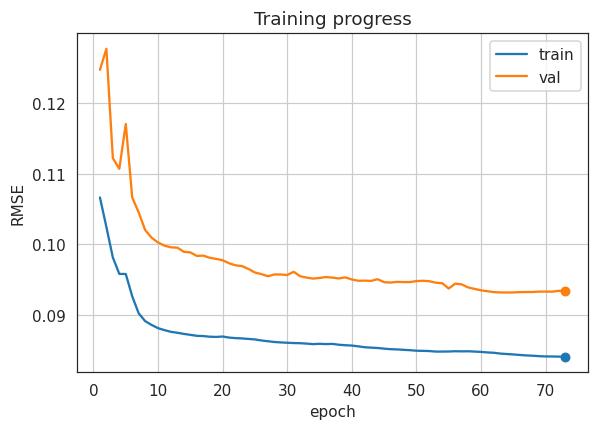

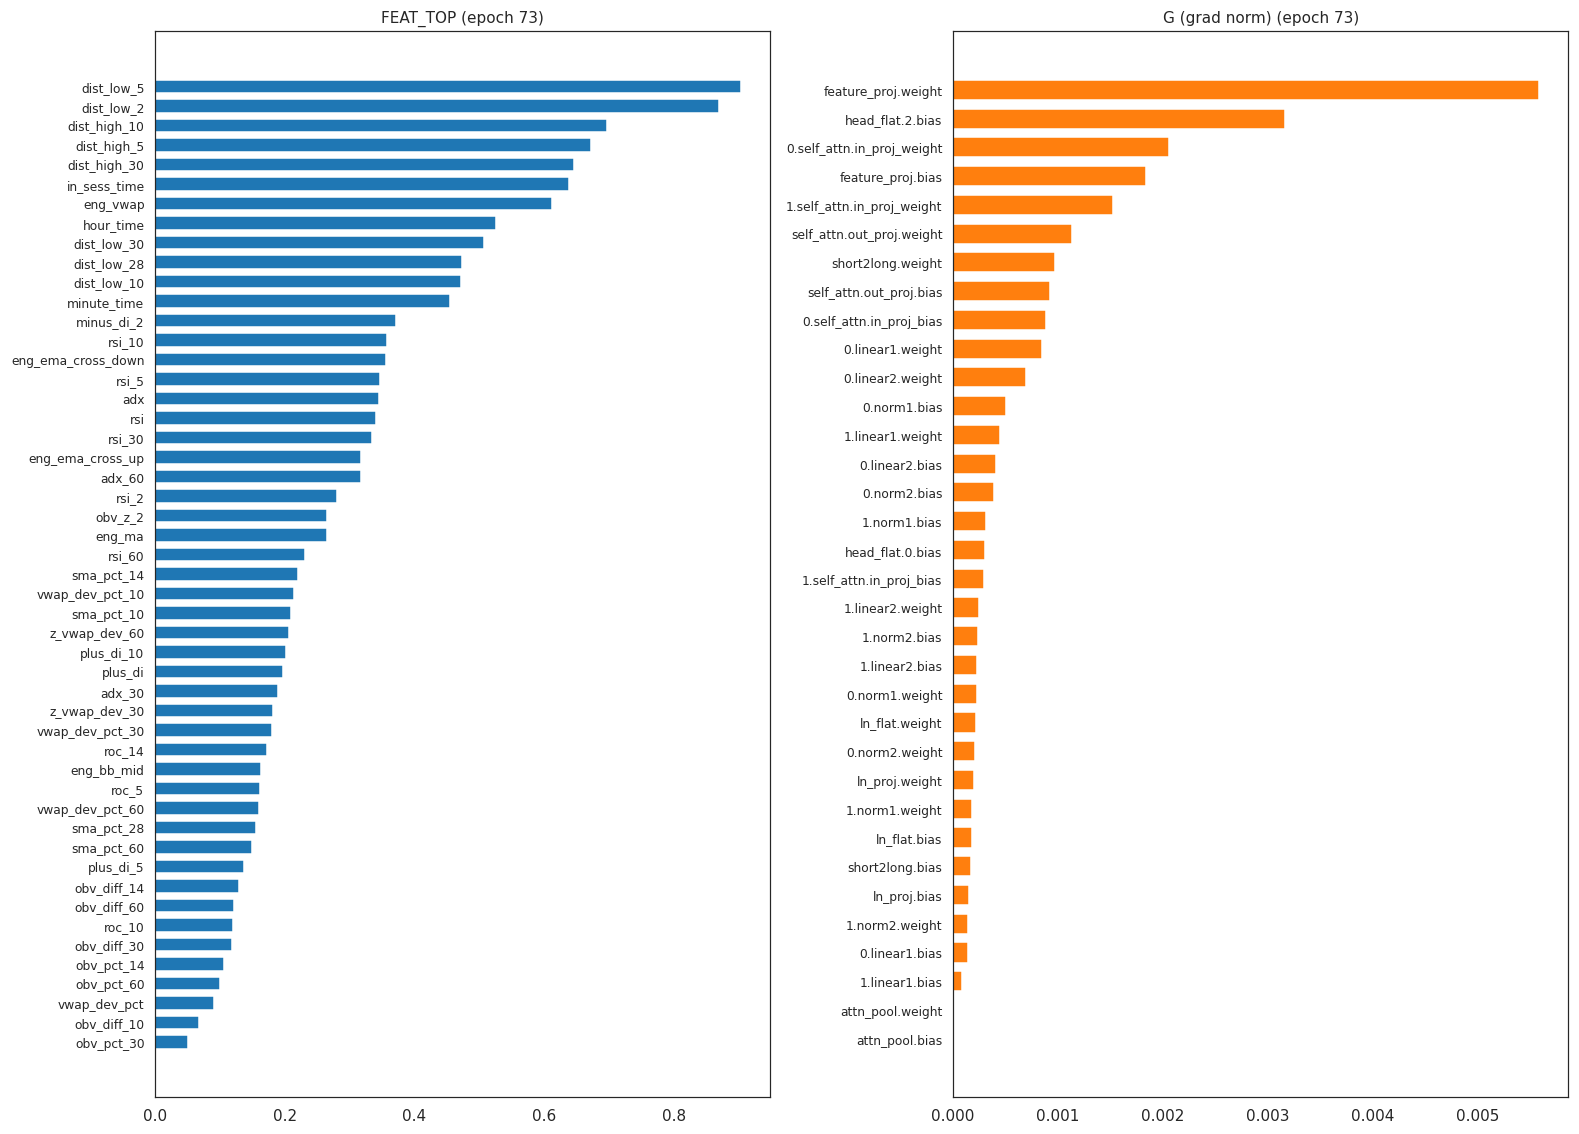

In [9]:
importlib.reload(params) #############
importlib.reload(models_custom) #############
importlib.reload(models_core) #############

n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: total={total_params:,}, trainable={trainable_params:,}\n")

print('Using HyperParameters:\n', params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models_custom.model_training_loop(
    model               = model,
    optimizer           = optimizer,
    scheduler           = scheduler,
    scaler              = GradScaler(),
    train_loader        = train_loader,
    val_loader          = val_loader
)